In [36]:
import warnings 
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay


sns.set_style('darkgrid')
cmap = sns.cm.mako_r

%matplotlib inline

In [37]:
stroke = pd.read_csv('./healthcare-dataset-stroke-data.csv')
stroke.head()
stroke.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [38]:
stroke.drop(columns=['id']).describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [39]:
stroke['age'] = stroke['age'].apply(lambda x : round(x))
stroke['bmi'] = stroke['bmi'].apply(lambda bmi_value: bmi_value if 12 < bmi_value < 60 else np.nan)
stroke.sort_values(['gender', 'age'], inplace=True) 
stroke.reset_index(drop=True, inplace=True)
stroke['bmi'].ffill(inplace=True)

In [40]:
stroke.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   int64  
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                5110 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 479.2+ KB


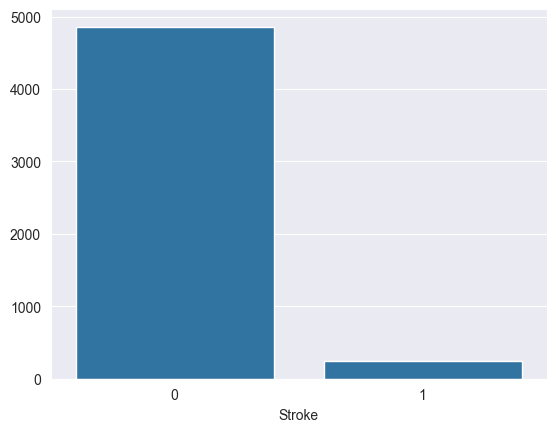

In [41]:
xaxis = stroke['stroke'].value_counts().index
yaxis = stroke['stroke'].value_counts().values

ax = sns.barplot(x=xaxis, y=yaxis)
ax.set_xlabel("Stroke")
plt.show()

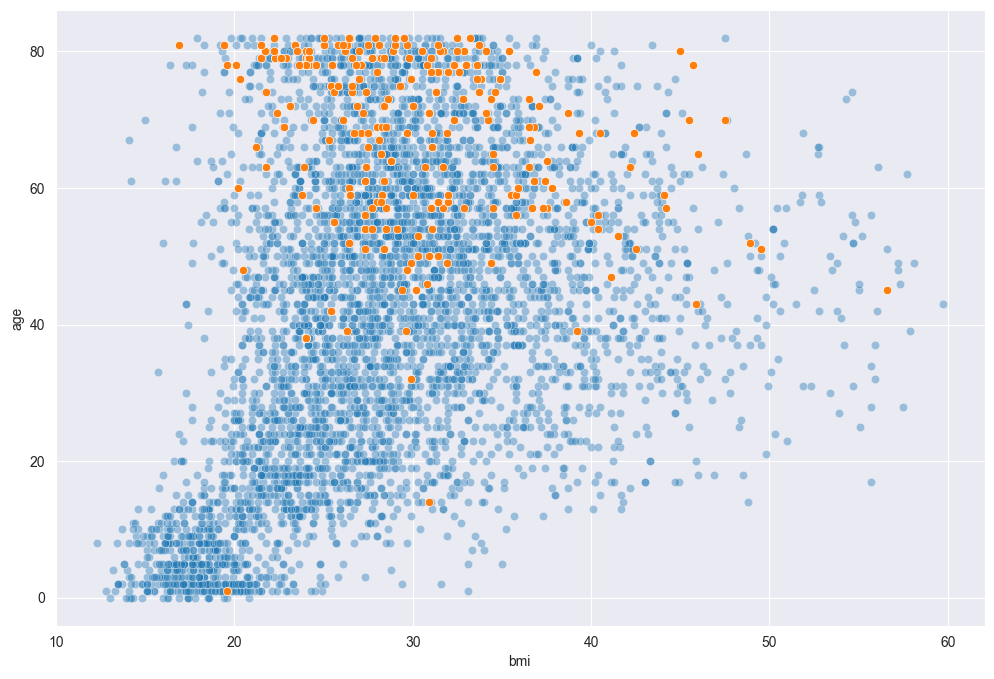

In [42]:
plt.figure(figsize=(12,8))
ax = sns.scatterplot(x="bmi", y="age", alpha=0.4, data=stroke[stroke['stroke'] == 0])
sns.scatterplot(x="bmi", y="age", alpha=1, data=stroke[stroke['stroke'] == 1], ax=ax)
plt.show()

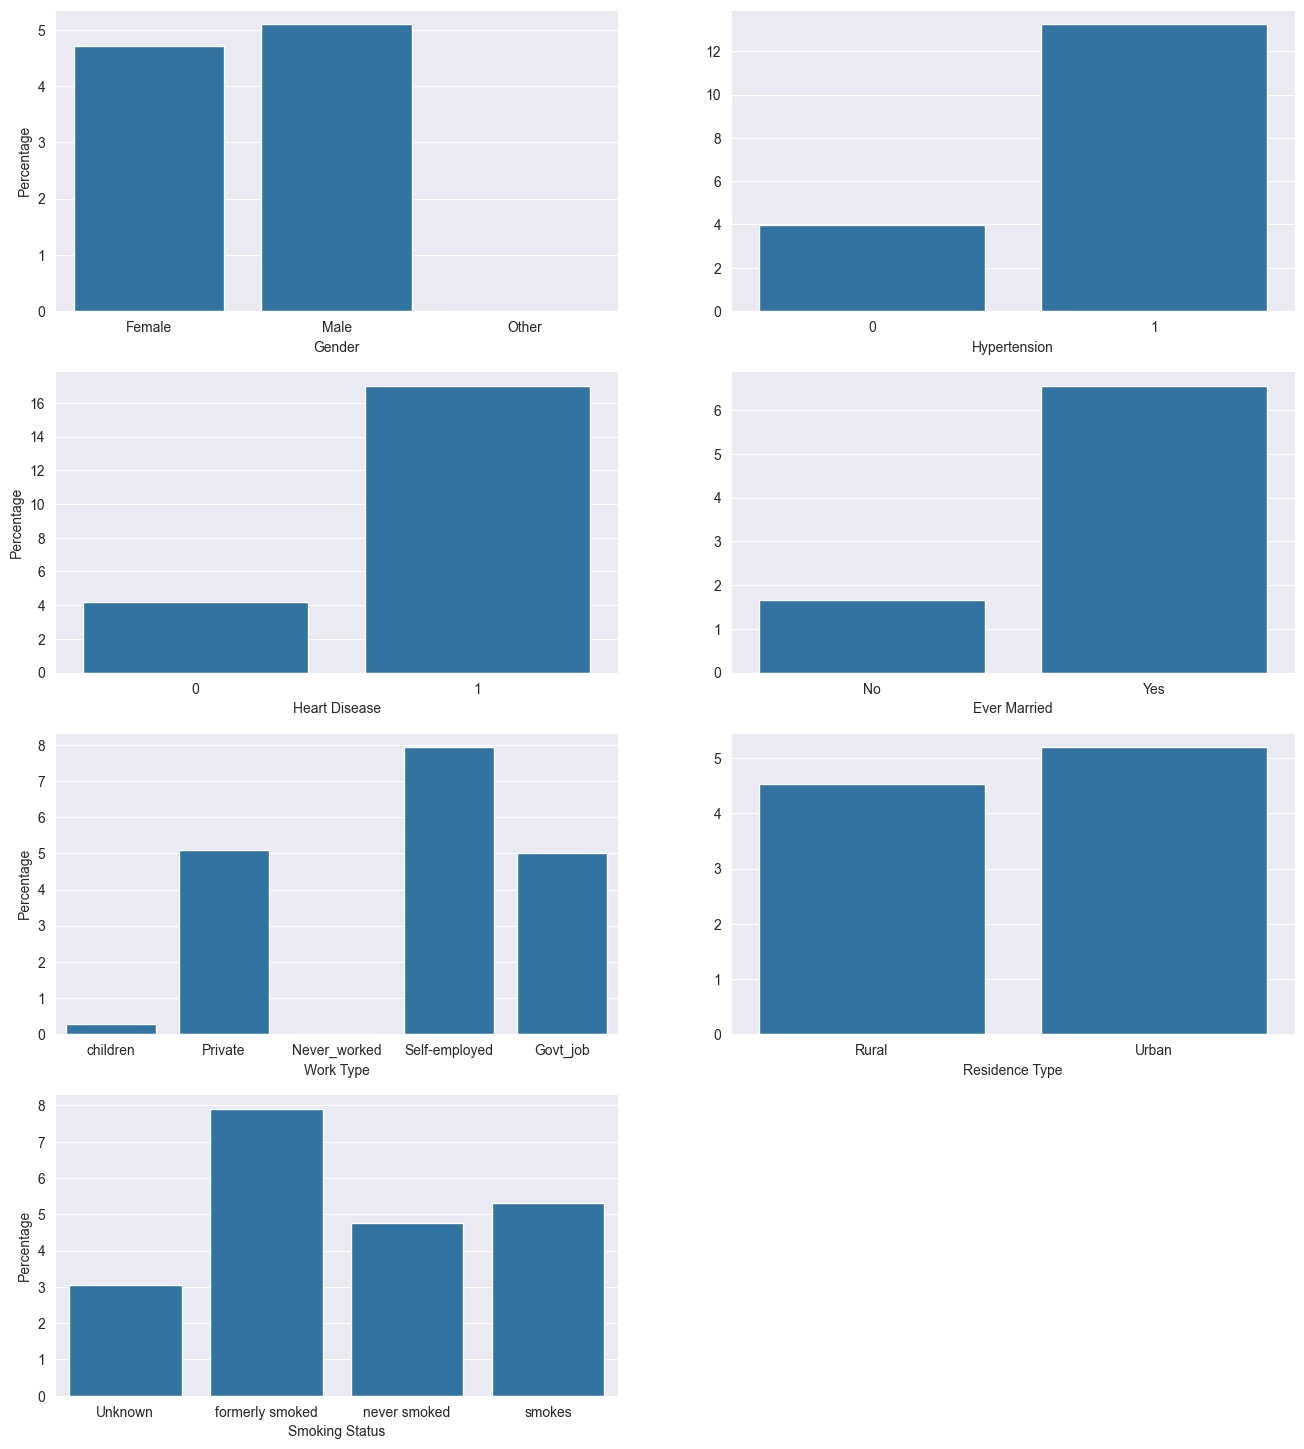

In [43]:
def plot_percent_of_stroke_in_each_category(df, column, axis):
    x_axis = []
    y_axis = []
    
    unique_values = df[column].unique()
    
    for value in unique_values:
        stroke_yes = len(df[(df[column] == value) & (df['stroke'] == 1)])
        total = len(df[df[column] == value])
        percentage = (stroke_yes/total) * 100
        x_axis.append(value)
        y_axis.append(percentage)
    
    sns.barplot(x=x_axis,y= y_axis, ax=axis)
    
columns = ['gender', 'hypertension', 'heart_disease', 'ever_married', 
           'work_type', 'Residence_type', 'smoking_status']

fig, axes = plt.subplots(4, 2, figsize=(16, 18))
axes[3, 1].remove()

plot_percent_of_stroke_in_each_category(stroke, 'gender', axes[0,0])
axes[0,0].set_xlabel("Gender")
axes[0,0].set_ylabel("Percentage")

plot_percent_of_stroke_in_each_category(stroke, 'hypertension', axes[0,1])
axes[0,1].set_xlabel("Hypertension")

plot_percent_of_stroke_in_each_category(stroke, 'heart_disease', axes[1,0])
axes[1,0].set_xlabel("Heart Disease")
axes[1,0].set_ylabel("Percentage")

plot_percent_of_stroke_in_each_category(stroke, 'ever_married', axes[1,1])
axes[1,1].set_xlabel("Ever Married")


plot_percent_of_stroke_in_each_category(stroke, 'work_type', axes[2,0])
axes[2,0].set_xlabel("Work Type")
axes[2,0].set_ylabel("Percentage")

plot_percent_of_stroke_in_each_category(stroke, 'Residence_type', axes[2,1])
axes[2,1].set_xlabel("Residence Type")

plot_percent_of_stroke_in_each_category(stroke, 'smoking_status', axes[3,0])
axes[3,0].set_xlabel("Smoking Status")
axes[3,0].set_ylabel("Percentage")

plt.show()

In [44]:
gender_dict = {'Male': 0, 'Female': 1, 'Other': 2}
ever_married_dict = {'No': 0, 'Yes': 1}
work_type_dict = {'children': 0, 'Never_worked': 1, 'Govt_job': 2, 'Private': 3, 'Self-employed': 4}
residence_type_dict = {'Rural': 0, 'Urban': 1}
smoking_status_dict = {'Unknown': 0, 'never smoked': 1, 'formerly smoked':2, 'smokes': 3}

In [45]:
stroke['gender'] = stroke['gender'].map(gender_dict)
stroke['ever_married'] = stroke['ever_married'].map(ever_married_dict)
stroke['work_type'] = stroke['work_type'].map(work_type_dict)
stroke['Residence_type'] = stroke['Residence_type'].map(residence_type_dict)
stroke['smoking_status'] = stroke['smoking_status'].map(smoking_status_dict)

In [46]:
X = stroke.drop(columns=['id', 'stroke'])
y = stroke['stroke']

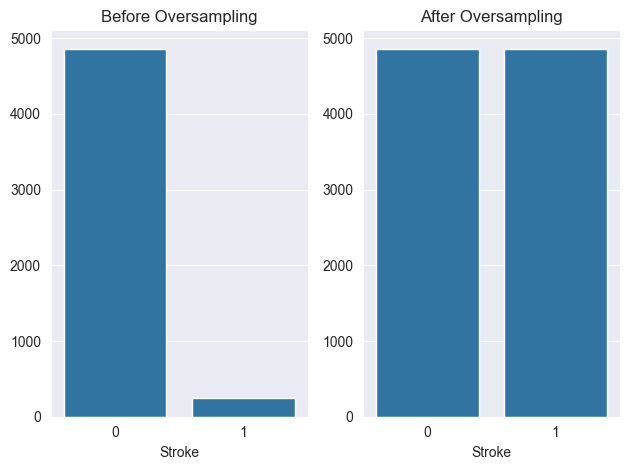

In [47]:
fig, (ax1, ax2) = plt.subplots(1, 2)

sns.barplot(x=['0', '1'], y =[sum(y == 0), sum(y == 1)], ax = ax1)
ax1.set_title("Before Oversampling")
ax1.set_xlabel('Stroke')


sm = SMOTE(random_state = 2) 
X, y = sm.fit_resample(X, y) 

sns.barplot(x=['0', '1'], y =[sum(y == 0), sum(y == 1)], ax = ax2)
ax2.set_title("After Oversampling")
ax2.set_xlabel('Stroke')

plt.tight_layout()
plt.show()

In [48]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=40)

In [49]:
pipeline = make_pipeline(StandardScaler(), RandomForestClassifier())
pipeline.fit(X_train, y_train)
prediction = pipeline.predict(X_test)

print(f"Accuracy Score : {round(accuracy_score(y_test, prediction) * 100, 2)}%")

Accuracy Score : 93.97%


In [50]:
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.96      0.92      0.94      1422
           1       0.93      0.96      0.94      1495

    accuracy                           0.94      2917
   macro avg       0.94      0.94      0.94      2917
weighted avg       0.94      0.94      0.94      2917



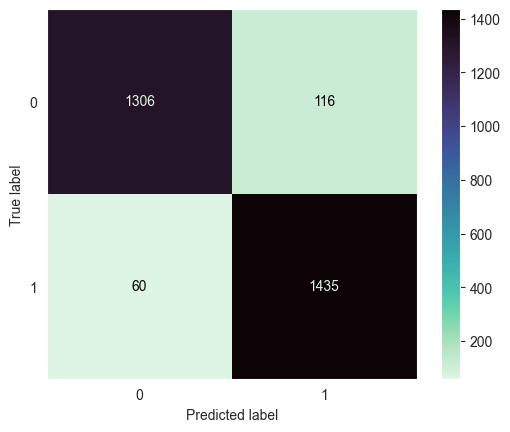

In [51]:
ConfusionMatrixDisplay.from_estimator(pipeline, X_test, y_test, cmap=cmap)
plt.grid(False)
plt.show()

In [52]:
import pickle

with open('./stroke_predictor.pkl', 'wb') as f:
    pickle.dump(pipeline, f)